In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# NAICS Embedding - Preliminary Plots
Plot embeddings from a couple sources, with different color schemes

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 

In [5]:
sg_plot.plot_defaults()

In [6]:
from sklearn.manifold import TSNE
from IPython.display import display, HTML

## Input Data
Create a table of NAICS info for plots

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [8]:
sba_loans.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'target', 'guaranteed_fract', 'new_business', 'urban_flag',
       'franchise_flag', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
       'NAICS_num', 'dset', 'dset_naics_holdout', 'menc_NAICS',
       'menc_NAICS_sector', 'NS___Accommodation and Food Services',
       'NS___Construction', 'NS___Health Care and Social Assistance',
       'NS___Manufacturing',
       'NS___Other Services (except Public Administration)',
       'NS___Professional, Scientific, and Technical Services',
       'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn',
       'cenc_NAICS'],
      dtype='object')

In [20]:
sba_loans['NAICS'].astype('int')

index
0         451120
1         722410
2         621210
5         332721
7         811118
           ...  
897159    332431
897160    314912
897162    451120
897163    451130
897164    332321
Name: NAICS, Length: 688081, dtype: int64

In [21]:
sba_loans['NAICS']

index
0         451120
1         722410
2         621210
5         332721
7         811118
           ...  
897159    332431
897160    314912
897162    451120
897163    451130
897164    332321
Name: NAICS, Length: 688081, dtype: object

In [9]:
#label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

In [10]:
# Businesses per NAICS count
naics_train_info = pd.read_parquet(Path(setup.temp_path).joinpath('55_DATA_naics_train_info.parquet'))

In [11]:
naics_train_info

,NAICS,count
0,722110,18218
1,722211,12712
2,811111,9264
3,621210,8997
4,624410,6432
...,...,...
1150,926120,1
1151,922150,1
1152,315992,1
1153,212399,1


##### Create NAICS info table

In [12]:
naics_info_df = sba_loans[['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
                           'menc_NAICS', 'menc_NAICS_sector', 'NAICS_num', 'dset_naics_holdout']].drop_duplicates('NAICS') \
    .merge(naics_train_info, how='left', on='NAICS') \
    .rename(columns={'NAICS':'NAICS_orig'}) \
    .set_index('NAICS_orig')
naics_info_df['count'] = naics_info_df['count'].fillna(0)

## Functions for Plotting Embeddings

##### Retrieving embeddings, TSNE and NAICS join

In [13]:
def get_transform_embeddings(filename, naics_df = naics_info_df,
                            naics_col = 'NAICS_orig'):
    """ Read embeddings file, TSNE transform and merge in NAICS info"""
    embed_df = pd.read_parquet(filename)
    emb_cols = [c for c in embed_df.columns if c.startswith('emb')]
    trans = TSNE(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(embed_df[emb_cols]), 
                                   index=embed_df[naics_col])
    
    emb_transformed = emb_transformed.merge(naics_df, left_index=True, right_index = True)
    emb_transformed['sector_num'] = emb_transformed['NAICS_sector'].str[0:2].astype('int')

    return emb_transformed

##### Plot joined embeddings

In [14]:
def emb_plot(tsne_df, color_var = 'sector_num', alpha=0.7,
            figsize = (7, 7), cmap = 'jet',
            title_str = None,
            aspect = 'equal',
            outfile_folder = None,
            outfile_prefix = None,
            log_scale = False):

    fig, ax = plt.subplots(figsize=figsize)
    s = ax.scatter(
        tsne_df[0],
        tsne_df[1],
        c=tsne_df[color_var],
        cmap=cmap,
        alpha=alpha,
    )
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    ax.set_aspect(aspect)
    if title_str is not None:
        plt.title(f'{title_str}\nby {color_var}')
    else:
        plt.title(f'TSNE by {color_var}')
    
    if not log_scale:
        norm = colors.Normalize(tsne_df[color_var].min(), tsne_df[color_var].max())
    else:
        norm = colors.LogNorm(tsne_df[color_var].min() + 0.002, tsne_df[color_var].max())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if outfile_folder is not None:
        fig.savefig(oufile_folder.joinpath(outfile_prefix + '_' + color_var + '.png'),
                    bbox_inches='tight')
    
    return fig

## Plot Embeddings

In [15]:
embed_dict = {'nn embed': Path(setup.temp_path).joinpath('12_DATA_embeddings.parquet'),
              'dgi base': Path(setup.temp_path).joinpath('41_DATA_embeddings.parquet'),
              'dgi label': Path(setup.temp_path).joinpath('43_DATA_embeddings.parquet'),
              'dgi nn features': Path(setup.temp_path).joinpath('45_DATA_embeddings.parquet'),
              'dgi nn feat, label': Path(setup.temp_path).joinpath('47_DATA_embeddings.parquet')}

In [16]:
# Calculate all embeddings with appended info fields
embed_df = pd.concat([get_transform_embeddings(v) for v in embed_dict.values()],
                     keys = embed_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'})

In [17]:
embed_df.head()

,model,0,1,NAICS_2,NAICS_sector,NAICS_sector_desc,menc_NAICS,menc_NAICS_sector,NAICS_num,dset_naics_holdout,count,sector_num
NAICS_orig,,,,,,,,,,,,
451120,nn embed,-23.447987,2.192110,45,44-45,Retail Trade,0.226320,0.225793,451120.0,0,1458.0,44
621210,nn embed,45.727993,10.134327,62,62,Health Care and Social Assistance,0.042130,0.100902,621210.0,0,8997.0,62
811118,nn embed,-3.589012,12.219856,81,81,Other Services (except Public Administration),0.147183,0.202440,811118.0,0,1298.0,81
721310,nn embed,51.076267,0.883733,72,72,Accommodation and Food Services,0.039976,0.217492,721310.0,0,76.0,72
811111,nn embed,3.857270,2.810340,81,81,Other Services (except Public Administration),0.155984,0.202440,811111.0,0,9264.0,81


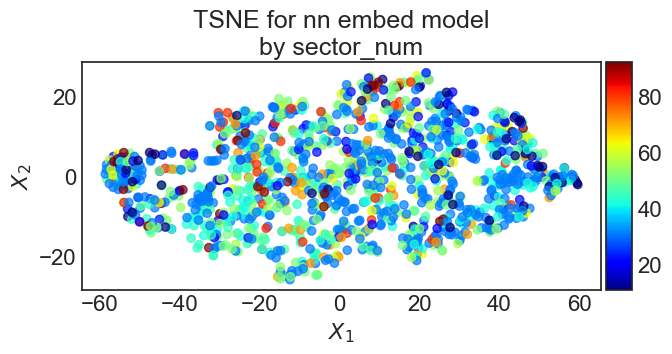

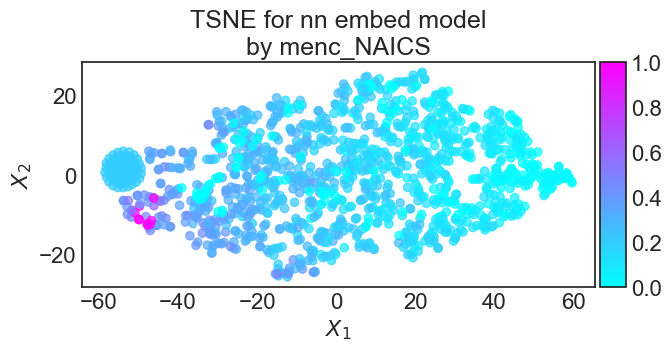

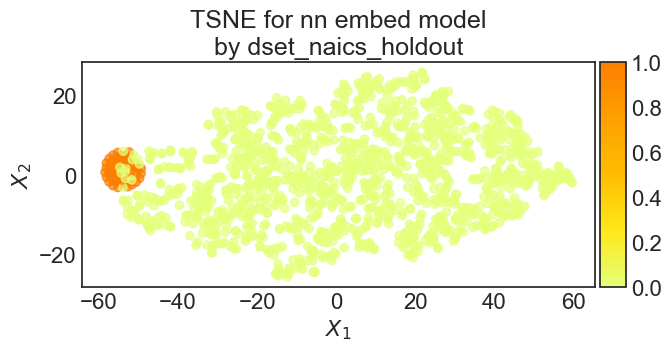

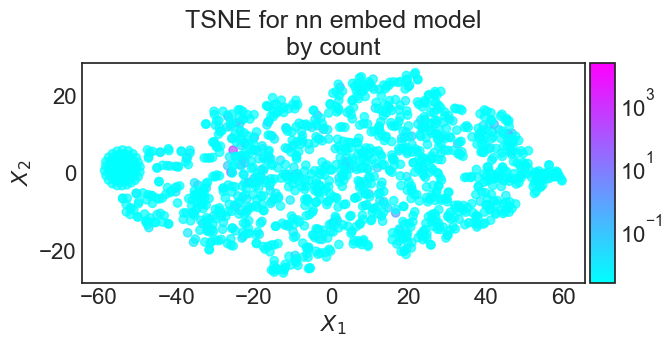

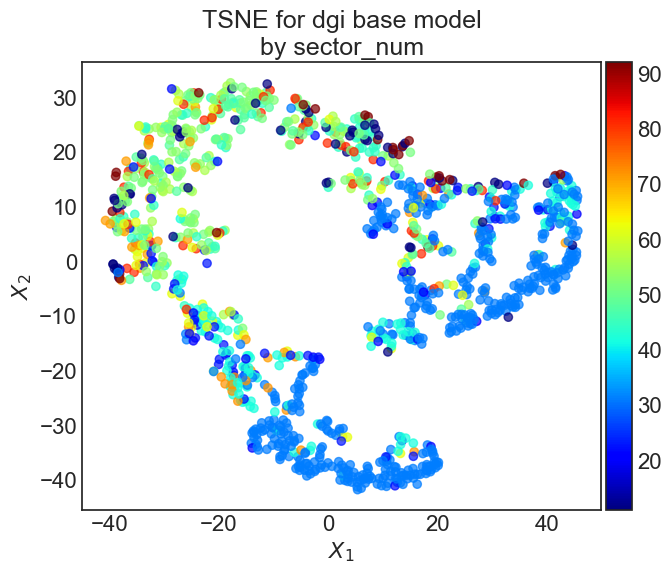

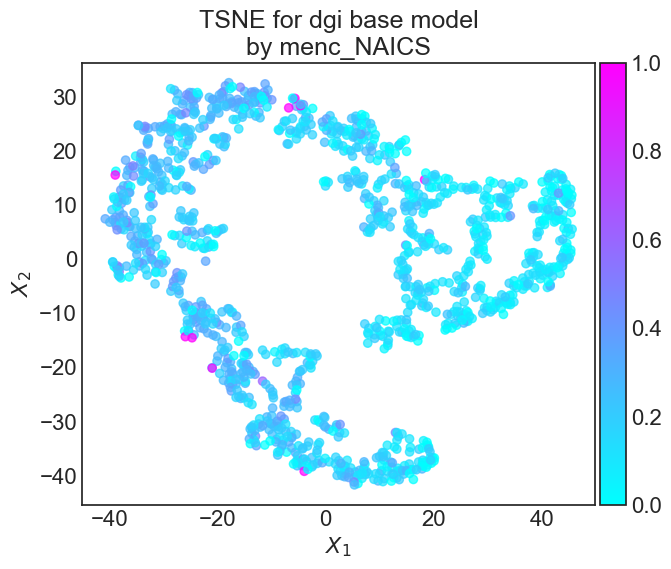

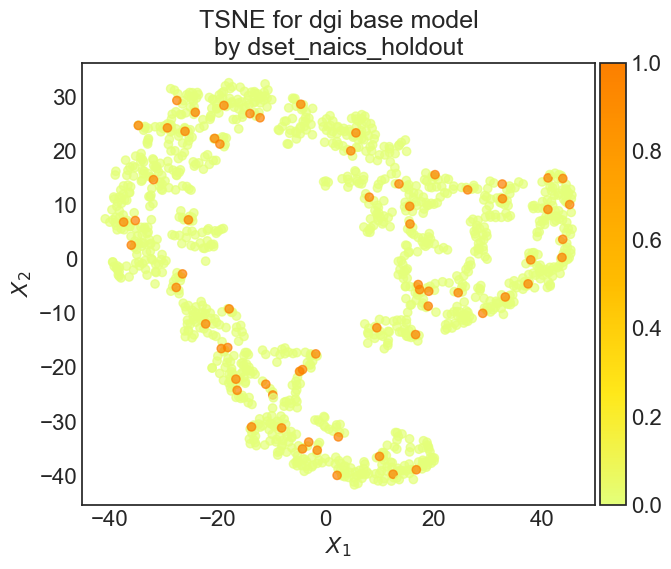

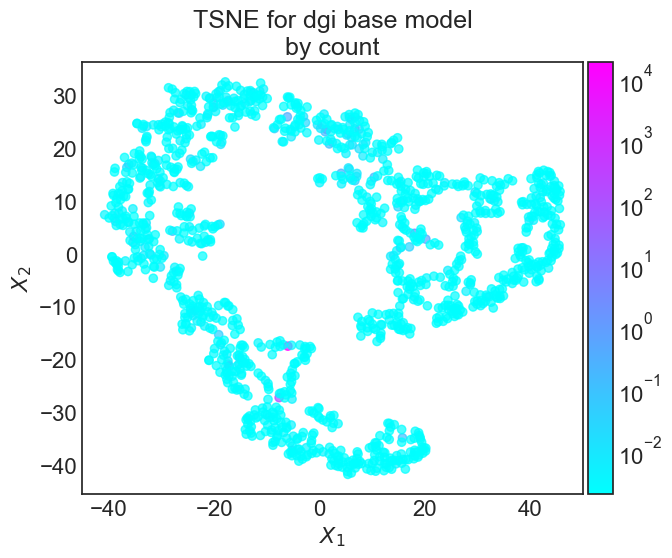

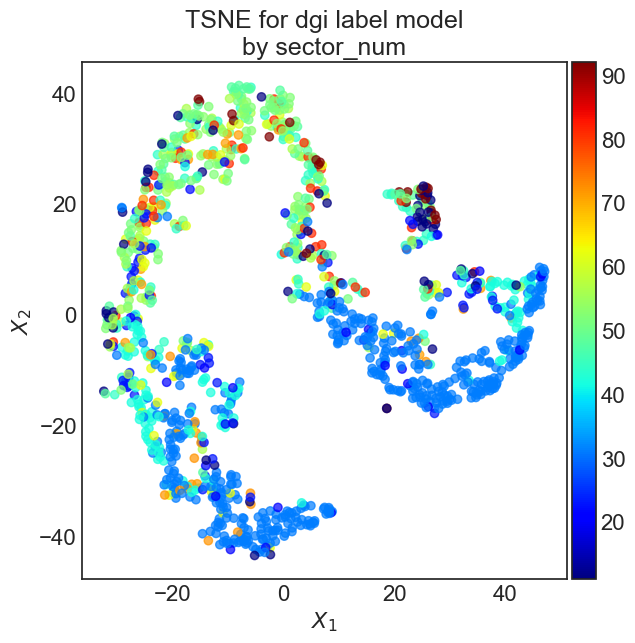

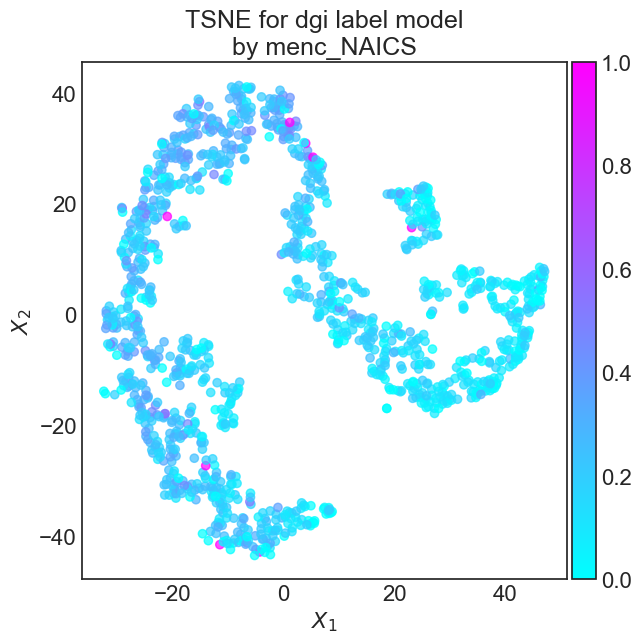

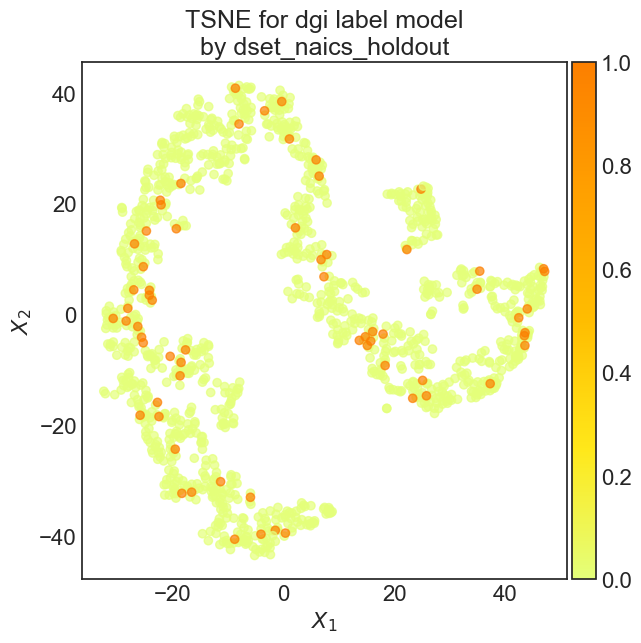

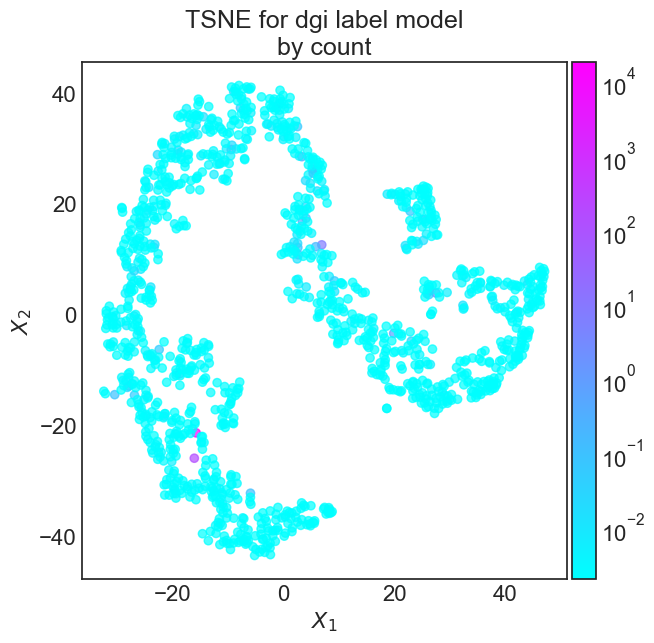

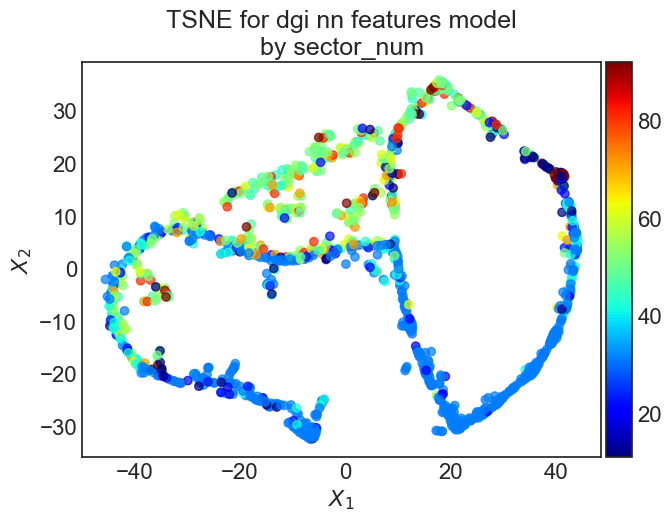

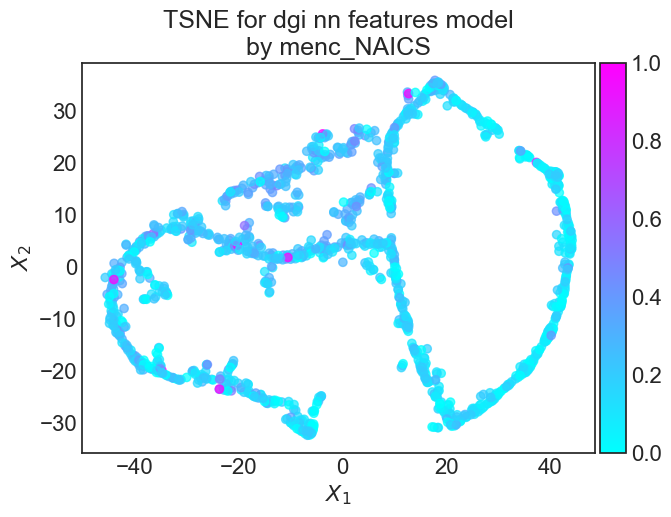

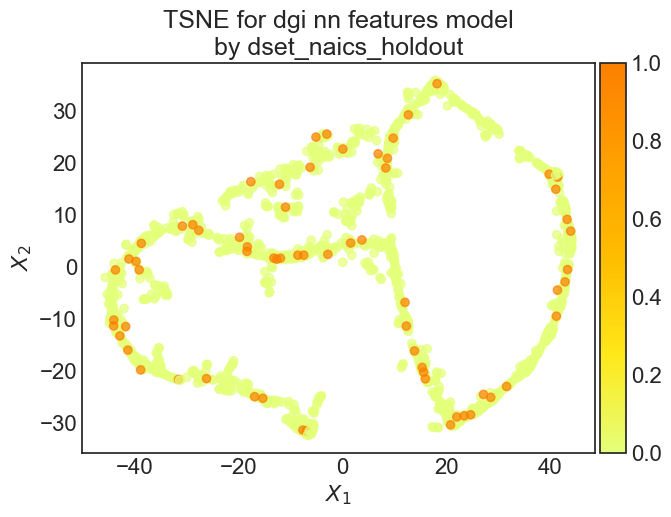

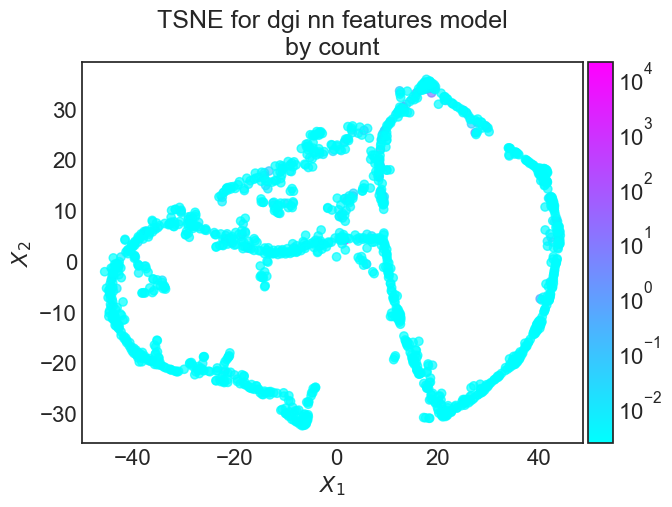

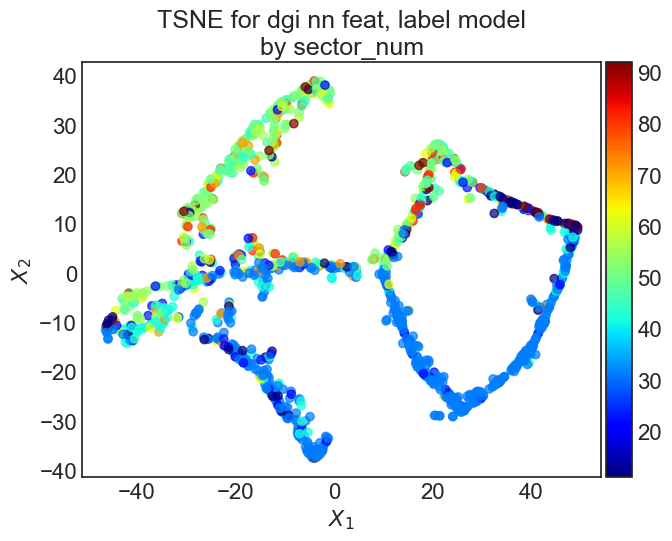

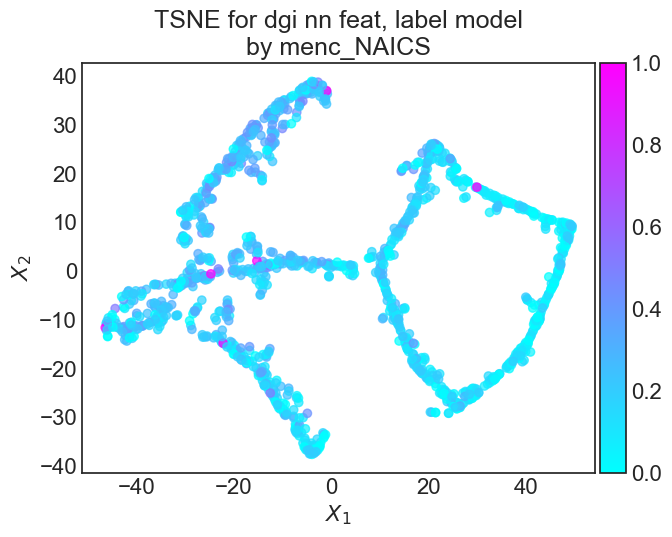

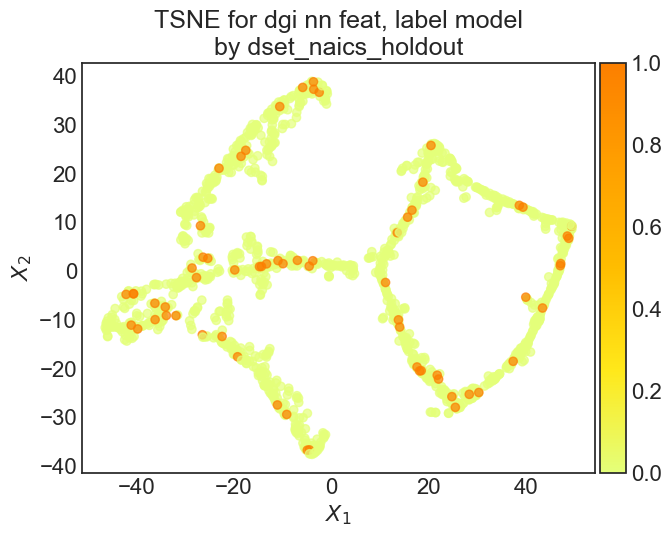

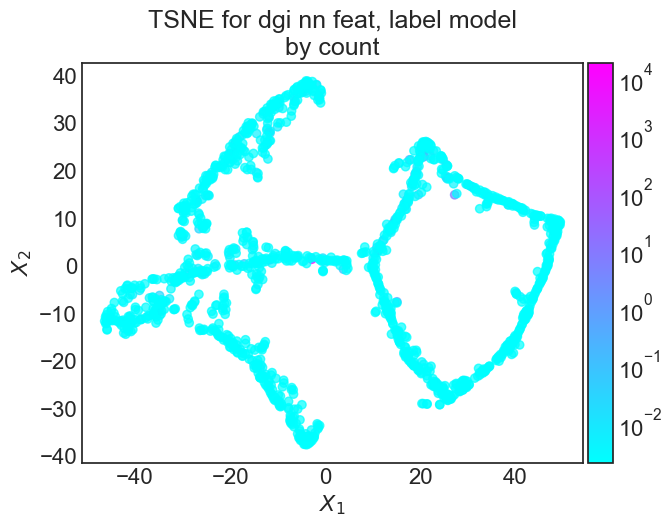

In [18]:
# Plot embeddings with several color schemes
for k, v in embed_dict.items():
    embed_trans_df = embed_df[embed_df['model'] == k]
    this_title = f'TSNE for {k} model'
    
    # NAICS sector
    fig = emb_plot(embed_trans_df, 'sector_num',
                  title_str = this_title, cmap = 'jet')
    fig
    
    # NAICS mean encoding
    fig = emb_plot(embed_trans_df, 'menc_NAICS',
                  title_str = this_title, cmap = 'cool')
    fig
    
    # Holdout status
    fig = emb_plot(embed_trans_df, 'dset_naics_holdout',
                  title_str = this_title, cmap = 'Wistia')
    fig
    
    # Code count
    fig = emb_plot(embed_trans_df, 'count',
                  title_str = this_title, cmap = 'cool', log_scale = True)
    fig

In [19]:
TO DO
- Rerunning 11, then do 12-16
- Consider re-numering 40

SyntaxError: invalid syntax (1764951846.py, line 1)